### Building the simple recommender is fairly straightforward. The steps are as follows:

1. Choose a metric (or score) to rate the movies on
2. Decide on the prerequisites for the movie to be featured on the chart
3. Calculate the score for every movie that satisfies the conditions
4. Output the list of movies in decreasing order of their scores

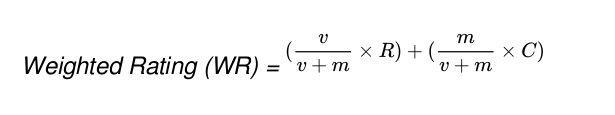

where:

v - the number of votes garnered by the movie.

m - the minimum number of votes required for the movie to be in the chart (the prerequisite).

R - the mean rating of the movie.

C - the mean rating of all the movies in the dataset.

In [39]:
import pandas as pd
import numpy as np

In [40]:
# Read the CSV File into df
df = pd.read_csv('movies_metadata.csv')

/home/josephitopa/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [41]:
df.shape

(45466, 24)

In [42]:
# Select the second movie in df
second = df.iloc[1]
second

adult                                                                False
belongs_to_collection                                                  NaN
budget                                                            65000000
genres                   [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...
homepage                                                               NaN
id                                                                    8844
imdb_id                                                          tt0113497
original_language                                                       en
original_title                                                     Jumanji
overview                 When siblings Judy and Peter discover an encha...
popularity                                                       17.015539
poster_path                               /vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg
production_companies     [{'name': 'TriStar Pictures', 'id': 559}, {'na...
production_countries     

In [43]:
# Change the index to the title
df = df.set_index('title')
# Access the movie with title 'Jumanji'
jum = df.loc['Jumanji']
jum

adult                                                                False
belongs_to_collection                                                  NaN
budget                                                            65000000
genres                   [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...
homepage                                                               NaN
id                                                                    8844
imdb_id                                                          tt0113497
original_language                                                       en
original_title                                                     Jumanji
overview                 When siblings Judy and Peter discover an encha...
popularity                                                       17.015539
poster_path                               /vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg
production_companies     [{'name': 'TriStar Pictures', 'id': 559}, {'na...
production_countries     

In [44]:
# Revert back to the previous zero-based indexing
df = df.reset_index()

In [45]:
# Create a smaller dataframe with a subset of all features
small_df = df[['title', 'release_date', 'budget', 'revenue', 'runtime','genres']]

In [46]:
# Get information of the data types of each feature
small_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         45460 non-null  object 
 1   release_date  45379 non-null  object 
 2   budget        45466 non-null  object 
 3   revenue       45460 non-null  float64
 4   runtime       45203 non-null  float64
 5   genres        45466 non-null  object 
dtypes: float64(2), object(4)
memory usage: 2.1+ MB


In [47]:
# Function to convert to float manually
def to_float(x):
    try:
        x = float(x)
    except:
        x = np.nan
    return x

In [48]:
# Convert release_date into pandas datetime format
small_df['release_date'] = pd.to_datetime(small_df['release_date'], errors='coerce')
# Extract year from the datetime
small_df['year'] = small_df['release_date'].apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)
# Display the DataFrame with the new 'year' feature
small_df.head()

<ipython-input-48-6049b6f0aed9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['release_date'] = pd.to_datetime(small_df['release_date'], errors='coerce')
<ipython-input-48-6049b6f0aed9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['year'] = small_df['release_date'].apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)


,title,release_date,budget,revenue,runtime,genres,year
0,Toy Story,1995-10-30,30000000,373554033.0,81.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",1995
1,Jumanji,1995-12-15,65000000,262797249.0,104.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",1995
2,Grumpier Old Men,1995-12-22,0,0.0,101.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",1995
3,Waiting to Exhale,1995-12-22,16000000,81452156.0,127.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",1995
4,Father of the Bride Part II,1995-02-10,0,76578911.0,106.0,"[{'id': 35, 'name': 'Comedy'}]",1995


In [55]:
# Calculate the number of votes garnered by the 80th percentile movie
m = df['vote_count'].quantile(0.80)
m # only 20% percent of the movie has more than 50 votes

50.0

In [50]:
# Only consider movies longer than 45 minutes and shorter than 300 minutes
q_movies = df[(df['runtime'] >= 45) & (df['runtime'] <= 300)]
# Only consider movies that have garnered more than m votes
q_movies = q_movies[q_movies['vote_count'] >= m]
# Inspect the number of movies that made the cut
q_movies.shape

(4512, 24)

In [51]:
# Calculate C
C = df['vote_average'].mean()
C

5.618207215133889

In [52]:
# Function to compute the IMDB weighted rating for each movie
def weighted_rating(x, m = m, C = C):
    v = x['vote_count']
    R = x['vote_average']
    # Compute the weighted score
    return (v / (v + m) * R) + (m / (m + v) * C)

In [53]:
# Compute the score using the weighted_rating function defined above
q_movies['score'] = q_movies.apply(weighted_rating, axis = 1)

In [54]:
q_movies.sort_values('score', ascending = False)

,title,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,release_date,revenue,runtime,spoken_languages,status,tagline,video,vote_average,vote_count,score
314,The Shawshank Redemption,False,NaN,25000000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",NaN,278,tt0111161,en,The Shawshank Redemption,...,1994-09-23,2.834147e+07,142.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Fear can hold you prisoner. Hope can set you f...,False,8.5,8358.0,8.445869
834,The Godfather,False,"{'id': 230, 'name': 'The Godfather Collection'...",6000000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",http://www.thegodfather.com/,238,tt0068646,en,The Godfather,...,1972-03-14,2.450664e+08,175.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,An offer you can't refuse.,False,8.5,6024.0,8.425439
10309,Dilwale Dulhania Le Jayenge,False,NaN,13200000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,19404,tt0112870,hi,Dilwale Dulhania Le Jayenge,...,1995-10-20,1.000000e+08,190.0,"[{'iso_639_1': 'hi', 'name': 'हिन्दी'}]",Released,Come... Fall In Love,False,9.1,661.0,8.421453
12481,The Dark Knight,False,"{'id': 263, 'name': 'The Dark Knight Collectio...",185000000,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",http://thedarkknight.warnerbros.com/dvdsite/,155,tt0468569,en,The Dark Knight,...,2008-07-16,1.004558e+09,152.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Why So Serious?,False,8.3,12269.0,8.265477
2843,Fight Club,False,NaN,63000000,"[{'id': 18, 'name': 'Drama'}]",http://www.foxmovies.com/movies/fight-club,550,tt0137523,en,Fight Club,...,1999-10-15,1.008538e+08,139.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Mischief. Mayhem. Soap.,False,8.3,9678.0,8.256385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9710,Son of the Mask,False,"{'id': 43072, 'name': 'The Mask Collection', '...",84000000,"[{'id': 14, 'name': 'Fantasy'}, {'id': 35, 'na...",NaN,10214,tt0362165,en,Son of the Mask,...,2005-02-18,0.000000e+00,94.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Who's next?,False,3.6,346.0,4.238168
12911,Disaster Movie,False,NaN,25000000,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",http://www.disastermovie.net/,13805,tt1213644,en,Disaster Movie,...,2008-08-29,1.410928e+07,87.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Your favorite movies are going to be destroyed.,False,3.1,250.0,4.082715
3471,Battlefield Earth,False,NaN,44000000,"[{'id': 28, 'name': 'Action'}, {'id': 878, 'na...",NaN,5491,tt0185183,en,Battlefield Earth,...,2000-05-10,2.140000e+07,118.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Take Back The Planet,False,3.0,259.0,3.999793
11557,Epic Movie,False,NaN,20000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,9760,tt0799949,en,Epic Movie,...,2007-01-25,8.686556e+07,86.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,We know it's big. We measured.,False,3.2,334.0,3.983225
